In [182]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [183]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Keras  1.0.7
Theano 0.8.0.dev0.dev-d94cdf4f23998cbff5f1f2fc0868d4f4d2de0d75
OpenCV 2.4.10
Numpy  1.10.4


In [184]:
import cPickle as pickle
from IPython import display
import matplotlib.pyplot as plot
from keras.models import model_from_json

class TrainingPlotter(Callback):
    def __init__(self, n=10, axis=None):
        self.history = []
        self.best_loss = np.inf
        self.best_epoch = 0
        self.nepochs = 0
        self.n = n
        self.line1 = None
        self.line2 = None
        self.axis = axis
        
    def __getstate__(self):
        # we do not want to pickle the matplotlib line1/line2/axis
        return dict(n=self.n, history=self.history, best_loss=self.best_loss, best_epoch=self.best_epoch, 
                    line1=None, line2=None, axis=None)

    def get_nepochs(self):
        return len(self.history)
    
    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        # {'acc': 0.97, 'loss': 0.08, 'val_acc': 0.98, 'val_loss': 0.06}
        epoch += self.nepochs
        
        if logs['val_loss'] < self.best_loss:
            self.best_loss = logs['val_loss']
            self.best_epoch = epoch
            rec = dict(best=True)
        else:
            rec = dict(best=False)
        rec.update(logs)
        self.history.append(rec)
        
        if self.axis is None:
            self.axis = plot

        try:
            if (len(self.history) % self.n) == 0:
                hvalid = np.array([v['val_loss'] for v in self.history], np.float32)
                htrain = np.array([v['loss'] for v in self.history], np.float32)
                vbest = np.flatnonzero(np.array([v['best'] for v in self.history]))

                if self.line1 is None:
                    self.line2 = self.axis.plot(htrain, label='training mse')[0]
                    self.line1 = self.axis.plot(hvalid, label='validation mse')[0]
                    self.axis.vlines(vbest[-1], 0, 1, colors='red', linestyles='dashed', label='validation min')
                else:
                    self.line2.set_xdata(np.arange(htrain.shape[0]))
                    self.line2.set_ydata(htrain)
                    self.line1.set_xdata(np.arange(hvalid.shape[0]))
                    self.line1.set_ydata(hvalid)
                    self.axis.vlines(vbest[-1], 0, 1, colors='red', linestyles='dashed')
                self.axis.legend()

                self.axis.title('Best loss is {:.5f} on epoch {:d}'.format(self.best_loss, self.best_epoch))
                self.axis.ylabel('Validation Loss [{:.5f} / {:.5f}]'.format(htrain[-1], hvalid[-1]))
                self.axis.xlabel('Epoch [{}]'.format(epoch))
                
                display.display(plot.gcf())
                display.clear_output(wait=True)

        except Exception as e:
            print '=*' * 40
            print 'Error while trying to plot losses...'
            print e
            print '*=' * 40
            raise
            
    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        self.nepochs = len(self.history)

    def on_train_end(self, logs={}):
        pass

    
def save_model(model, name, overwrite=False):
    model_fn = name + '.model'
    weights_fn = name + '.weights'
    history_fn = name + '.history'
    open(model_fn, 'w').write(model.to_json())
    pickle.dump(model.hplotter, open(history_fn, 'wb'))
    if not overwrite and os.path.isfile(weights_fn):
        return
    model.save_weights(weights_fn, overwrite=True)
    
def load_model(name):
    model, pltr = None, None
    model_fn = name + '.model'
    weights_fn = name + '.weights'
    history_fn = name + '.history'
    if os.path.isfile(model_fn):
        model = model_from_json(open(model_fn).read())
        if os.path.isfile(weights_fn):
            model.load_weights(weights_fn)
        if os.path.isfile(history_fn):
            model.hplotter = pickle.load(open(history_fn, 'rb'))
    return model


In [185]:
# grab the MNIST dataset (if this is your first time running this
# script, the download may take a minute -- the 55MB MNIST dataset
# will be downloaded)
print("[INFO] downloading MNIST...")
dataset = datasets.fetch_mldata("MNIST Original", data_home='.', )
 
# reshape the MNIST dataset from a flat list of 784-dim vectors, to
# 28 x 28 pixel images, then scale the data to the range [0, 1.0]
# and construct the training and testing splits
data = dataset.data.reshape((dataset.data.shape[0], 28, 28))
data = data[:, np.newaxis, :, :]

(trainData, testData, trainLabels, testLabels) = \
        train_test_split(data / 255.0, dataset.target.astype("int"), test_size=0.33)

# transform the training and testing labels into vectors in the
# range [0, classes] -- this generates a vector for each label,
# where the index of the label is set to `1` and all other entries
# to `0`; in the case of MNIST, there are 10 class labels
trainLabels = np_utils.to_categorical(trainLabels, 10)
testLabels = np_utils.to_categorical(testLabels, 10)


[INFO] downloading MNIST...


In [186]:
model_name = './keras_lenet_dropout'

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Convolution2D(20, 5, 5, border_mode="same", input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Dropout(0.5))
        
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = LeNet.build(width=28, height=28, depth=1, classes=10)
    model.hplotter = TrainingPlotter(n=1)
    save_model(model, model_name, overwrite=True)


[INFO] evaluating...
23100/23100 [==============================] - 5s     
[INFO] accuracy: 96.86%


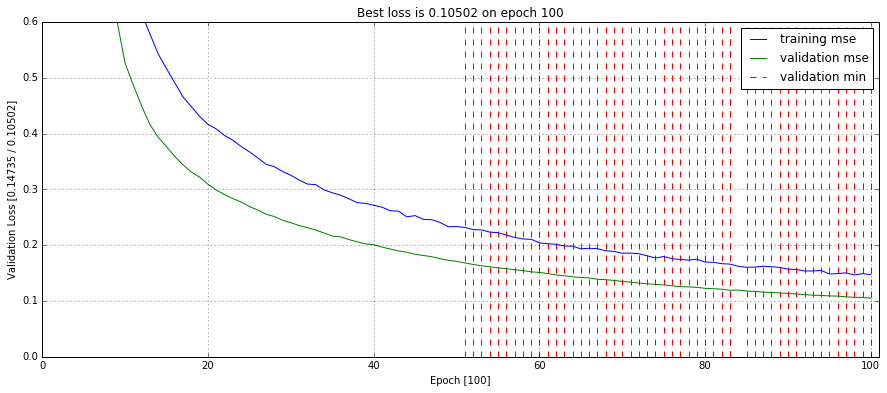

In [187]:
trainIt = 1
nepochs = 50

print("[INFO] loading model...")
model = load_model(model_name)

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

if trainIt > 0:
    trplotter = model.hplotter
    
    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, 0.6)
    plot.xlim(0, nepochs + trplotter.get_nepochs())
    plot.grid(True)
    
    check_ptr = ModelCheckpoint(filepath=model_name + '.weights', verbose=0, save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=15)
    # lr_sched = LearningRateScheduler()

    print("[INFO] training...")
    try:
        histo2 = model.fit(trainData, trainLabels, batch_size=128, nb_epoch=nepochs, verbose=0,
                           validation_split=0.33, callbacks=[trplotter, check_ptr, early_stop])
    except KeyboardInterrupt:
        pass

    save_model(model, model_name)
    
print("[INFO] evaluating...")
(loss, accuracy) = model.evaluate(testData, testLabels, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


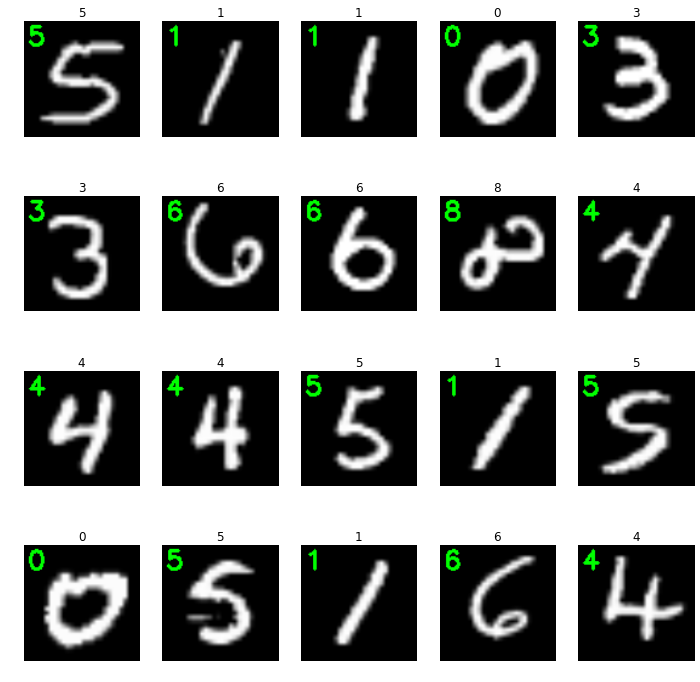

In [188]:
# randomly select a few testing digits
plot.figure(figsize=(12, 12))

for k, i in enumerate(np.random.choice(np.arange(0, len(testLabels)), size=(20,))):
    plot.subplot(4, 5, k + 1)
    # classify the digit
    probs = model.predict(testData[np.newaxis, i])
    prediction = probs.argmax(axis=1)

    # resize the image from a 28 x 28 image to a 96 x 96 image so we
    # can better see it
    image = (testData[i][0] * 255).astype("uint8")
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(prediction[0]), (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # show the image and prediction
    vreal = np.argmax(testLabels[i])
    # print("[INFO] Predicted: {}, Actual: {}".format(prediction[0], vreal))
    plot.imshow(image)
    plot.axis('off')
    plot.title('{}'.format(vreal))
